<a href="https://colab.research.google.com/github/pr-shukla/MS-Thesis/blob/main/multi_coop_pursuer_comp_evader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.3.1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.3.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import math
from tensorflow.keras.models import load_model
from matplotlib import animation

In [ ]:
#Dimension of State Space for single agent
dim_agent_state = 5


#Time Difference Between 2 Steps
dt = 0.4

#Number of Episodes
num_episodes = 3000

#Number of Steps

num_steps = 100




#velocity of pursuer
v = 1.0


#Velocity of Evader during training
ve = 0.9

#Minimum turing radius of Pursuer
rho = 0.3#3*v
rho_e = 0.3#3*ve

#angle between initial velocity and reference
te = 3*np.pi/4

num_agents = 3

#Dimension of State Space
dim_state = dim_agent_state*num_agents

In [ ]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=0.4, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [ ]:
class Buffer:
    def __init__(self, buffer_capacity=10000, batch_size=64):

        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, dim_state))
        self.action_buffer = np.zeros((self.buffer_capacity, num_agents))
        self.reward_buffer = np.zeros((self.buffer_capacity, num_agents))
        self.next_state_buffer = np.zeros((self.buffer_capacity, dim_state))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self, ac_models, cr_models, target_ac, target_cr):
      for i in range(num_agents):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.

        target_actions = np.zeros((self.batch_size, num_agents))
        for j in range(num_agents):
          target_actions[:,j] = tf.reshape(
              target_ac[j](next_state_batch[:,5*j:5*(j+1)]), [self.batch_size]
              )

        target_action_batch1 = target_actions[:,0]
        target_action_batch2 = target_actions[:,1]
        target_action_batch3 = target_actions[:,2]
        action_batch1 = action_batch[:,0]
        action_batch2 = action_batch[:,1]
        action_batch3 = action_batch[:,2]
    
        with tf.GradientTape() as tape:
            y = reward_batch[:,i] + gamma * target_cr[i]([
                                                          next_state_batch, target_action_batch1, 
                                                          target_action_batch2, target_action_batch3
                                                          ])
            
            critic_value = cr_models[i]([
                                         state_batch, action_batch1, action_batch2, action_batch3
                                         ])
            
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, cr_models[i].trainable_variables)
        #print(np.shape(critic_grad[0]),np.shape(critic_grad[1]))
        critic_optimizer.apply_gradients(
            zip(critic_grad, cr_models[i].trainable_variables)
        )

        actions = np.zeros((self.batch_size, num_agents))
        for j in range(num_agents):
          a = ac_models[j](state_batch[:,5*j:5*(j+1)])
          actions[:,j] = tf.reshape(a, [self.batch_size])

  

        #print(np.shape(ac_gradient[0]),np.shape(ac_gradient[1]))

        if i == 0:

          
          with tf.GradientTape(persistent=True) as tape:
              
              action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][0]]))
              
              critic_value = cr_models[i]([np.array([state_batch[0]]), action_, np.array([actions[:,1][0]]),
                                           np.array([actions[:,2][0]])])

          critic_grad = tape.gradient(critic_value, action_)
          actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)

          
          new_actor_grad = [critic_grad[0][0]*element for element in actor_grad]

          for k in range(1,self.batch_size):
              with tf.GradientTape(persistent=True) as tape:
                  
                  action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][k]]))
                  
                  critic_value = cr_models[i]([np.array([state_batch[k]]), action_, np.array([actions[:,1][k]]),
                                               np.array([actions[:,2][k]])])

              critic_grad = tape.gradient(critic_value, action_)
              actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)

              for l in range(len(new_actor_grad)):
                new_actor_grad[l] = new_actor_grad[l] + critic_grad[0][0]*actor_grad[l]


          new_actor_grad = [-1*element/self.batch_size for element in new_actor_grad]
          actor_optimizer.apply_gradients(zip(new_actor_grad, ac_models[i].trainable_variables))
          
          
          

        elif i == 1:

          
          continue
          
          with tf.GradientTape(persistent=True) as tape:
              
              action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][0]]))
              
              critic_value = cr_models[i]([np.array([state_batch[0]]), np.array([actions[:,0][0]]),action_,
                                           np.array([actions[:,2][0]])])

          critic_grad = tape.gradient(critic_value, action_)
          actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)

          
          new_actor_grad = [critic_grad[0][0]*element for element in actor_grad]

          for k in range(1,self.batch_size):
              with tf.GradientTape(persistent=True) as tape:
                  
                  action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][k]]))
                  
                  critic_value = cr_models[i]([np.array([state_batch[k]]), np.array([actions[:,0][k]]),action_,
                                               np.array([actions[:,2][k]])])

              critic_grad = tape.gradient(critic_value, action_)
              actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)

              for l in range(len(new_actor_grad)):
                new_actor_grad[l] = new_actor_grad[l] + critic_grad[0][0]*actor_grad[l]


          new_actor_grad = [-1*element/self.batch_size for element in new_actor_grad]
          actor_optimizer.apply_gradients(zip(new_actor_grad, ac_models[i].trainable_variables))

        else:
          with tf.GradientTape(persistent=True) as tape:
              
              action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][0]]))
              
              critic_value = cr_models[i]([np.array([state_batch[0]]), np.array([actions[:,0][0]]),
                                           np.array([actions[:,1][0]]), action_])

          critic_grad = tape.gradient(critic_value, action_)
          actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)

          
          new_actor_grad = [critic_grad[0][0]*element for element in actor_grad]

          for k in range(1,self.batch_size):
              with tf.GradientTape(persistent=True) as tape:
                  
                  action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][k]]))
                  
                  critic_value = cr_models[i]([np.array([state_batch[k]]), np.array([actions[:,0][k]]),
                                               np.array([actions[:,1][k]]), action_])

              critic_grad = tape.gradient(critic_value, action_)
              actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)

              for l in range(len(new_actor_grad)):
                new_actor_grad[l] = new_actor_grad[l] + critic_grad[0][0]*actor_grad[l]


          new_actor_grad = [-1*element/self.batch_size for element in new_actor_grad]
          actor_optimizer.apply_gradients(zip(new_actor_grad, ac_models[i].trainable_variables))


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau, ac_models, cr_models, target_ac, target_cr):
  for i in range(num_agents):
    new_weights = []
    target_variables = target_cr[i].weights
    for j, variable in enumerate(cr_models[i].weights):
        new_weights.append(variable * tau + target_variables[j] * (1 - tau))

    target_cr[i].set_weights(new_weights)

    new_weights = []
    target_variables = target_ac[i].weights
    for j, variable in enumerate(ac_models[i].weights):
        new_weights.append(variable * tau + target_variables[j] * (1 - tau))

    target_ac[i].set_weights(new_weights)

In [ ]:

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.00003, maxval=0.00003)

    inputs = layers.Input(shape=(5,))
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs 
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    # State as input
    state_input = layers.Input(shape=(dim_state))
    state_out = layers.Dense(16, activation="selu", kernel_initializer="lecun_normal")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(state_out)
    state_out = layers.BatchNormalization()(state_out)

    # Action as input
    action_input1 = layers.Input(shape=(1))
    action_input2 = layers.Input(shape=(1))
    action_input3 = layers.Input(shape=(1))
    action_input = layers.Concatenate()([action_input1, action_input2, action_input3])
    action_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(action_input)
    action_out = layers.BatchNormalization()(action_out)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(concat)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    
    outputs = layers.Dense(1)(out)


    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input1, action_input2, action_input3], outputs)

    return model

In [ ]:
def policy(state, noise_object, model):
    
    sampled_actions = tf.squeeze(model(state))
    noise = noise_object()

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)

    return [np.squeeze(legal_action)]



In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

ac_models = []
cr_models = []
target_ac = []
target_cr = []

for i in range(num_agents):
  ac_models.append(get_actor()) 
  cr_models.append(get_critic())

  target_ac.append(get_actor())
  target_cr.append(get_critic())

  # Making the weights equal initially
  target_ac[i].set_weights(ac_models[i].get_weights())
  target_cr[i].set_weights(cr_models[i].get_weights())


# Learning rate for actor-critic models
#critic_lr = 1e-3
#actor_lr = 5e-4
critic_lr = 1e-4
actor_lr = 5e-5


critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Discount factor for future rewards
gamma = 0.95
# Used to update target networks
tau = 0.005

buffer = Buffer(10000, 1)

In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

ac_models = []
cr_models = []
target_ac = []
target_cr = []

for i in range(num_agents):
  ac_models.append(load_model('/content/drive/MyDrive/MS_Project/Trained_Models/actor'+str(i)+'.h5')) 
  cr_models.append(load_model('/content/drive/MyDrive/MS_Project/Trained_Models/critic'+str(i)+'.h5'))

  target_ac.append(load_model('/content/drive/MyDrive/MS_Project/Trained_Models/target_actor'+str(i)+'.h5'))
  target_cr.append(load_model('/content/drive/MyDrive/MS_Project/Trained_Models/target_critic'+str(i)+'.h5'))

'''
ac_models.append(get_actor()) 
cr_models.append(get_critic())

target_ac.append(get_actor())
target_cr.append(get_critic())

# Making the weights equal initially
target_ac[i].set_weights(ac_models[i].get_weights())
target_cr[i].set_weights(cr_models[i].get_weights())
'''

'''for i in range(num_agents):
  ac_models[i].save('actor'+str(i)+'.h5') 
  cr_models[i].save('critic'+str(i)+'.h5')

  target_ac[i].save('target_actor' + str(i)+'.h5')
  target_cr[i].save('target_critic' + str(i)+'.h5')'''
# Learning rate for actor-critic models
#critic_lr = 1e-3
#actor_lr = 5e-4
critic_lr = 1e-4
actor_lr = 5e-5


critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Discount factor for future rewards
gamma = 0.95
# Used to update target networks
tau = 0.005

buffer = Buffer(10000, 1)
print(len(ac_models))

3


In [ ]:
#Function for generating sigmoid output of Input Function
def sigmoid(x):
    val = 1/(1+np.exp(-x))
    return val

#Calculating Distance between Pursuer and Evader
def L(rx1, ry1, rx2, ry2):
    d = np.sqrt((rx2-rx1)**2 + (ry2-ry1)**2)
    return d


#Calculating angle between velocity and reference axis
def thetap(vx, vy, v):

    angle = math.acos(vx/v)*((vy+0.001)/abs(vy+0.001))-np.pi*((vy+0.0001)/(abs(vy)+0.0001)-1)
    return angle

def alph(state):
    l = L(state)
    angle = math.acos((state[4]-state[0])/l)*(state[5]-state[1]+0.0001)/abs(state[5]-state[1]+0.0001)-(np.pi)*(((state[5]-state[1]+0.0001)/abs(0.0001+state[5]-state[1]))-1)
    return angle

#Reward Calculator
def reward(state):
  rewards = []
  for i in range(num_agents):
    '''
    ag_state = []
    for j in state[i*4:(i+1)*4]:
      ag_state.append(j)
    for j in ev_state:
      ag_state.append(j)
    '''

    if i == 2:
      r1 = 10*state[0+i*5]#-10*np.exp(-3*state[0+i*5])
      r2 = 10*np.exp(-1*state[1+i*5])
      r3 = 5*np.arctan(1*state[2+i*5])
      r4 = 10*state[2+i*5]#-10*np.exp(-3*state[2+i*5])
      r5 = 10*np.exp(-1*state[0+i*5]*state[3+i*5])
      r =  r1  + r4 #+ r2  #+ r3 
      
      rewards.append(r)

    else:

      r1 = 10*np.exp(-3*state[0+i*5])
      r2 = 10*np.exp(-1*state[1+i*5])
      r3 = 5*np.arctan(1*state[2+i*5])
      r4 = 10*np.exp(-3*state[3+i*5])
      r5 = 10*np.exp(-1*state[0+i*5]*state[3+i*5])
      r =  r1  + r2 + r3 + r4 #+ r2  #+ r3 
      
      rewards.append(r)

  return rewards

#Calculator of Angle between velocity and line joining Evader and Pursuer
def phi(rx1, ry1, vx1, vy1, rx2, ry2, v):
    d = L(rx1, ry1, rx2, ry2)
    rx2_rx1 = rx2 - rx1
    ry2_ry1 = ry2 - ry1
    angle = math.acos(round((rx2_rx1*vx1+ ry2_ry1*vy1)/(d*v), 4))
    return angle


In [ ]:
import random
class environment:
  def __init__(self):
    self.p1_rx = random.uniform(0.0, 5.0)
    self.p1_ry = random.uniform(0.0, 5.0)
    self.p2_rx = random.uniform(0.0, 5.0)
    self.p2_ry = random.uniform(0.0, 5.0)
    self.p1_vx = v
    self.p1_vy = 0.0
    self.p2_vx = v
    self.p2_vy = 0.0
    self.e_rx = random.uniform(0.0, 5.0)
    self.e_ry = random.uniform(0.0, 5.0)
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                   self.p1_ry]
    state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                   self.p1_ry]
    return state_p1_e, state_p2_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    d_e_p1 = d_p1_e
    d_e_p2 = d_p2_e
    
    phi_p1_e  = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry, v)
    phi_p1_p2 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                  self.p2_ry, v)
    phi_p2_e  = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry, v)
    phi_p2_p1 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                  self.p1_ry, v)
    phi_e_p1  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                  self.p1_ry, ve)
    phi_e_p2  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p2_rx,
                  self.p2_ry, ve)
    
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0, d_p1_p2/30.0, phi_p1_p2/np.pi,
           d_p2_e/30.0, phi_p2_e/np.pi, 0.0, d_p2_p1/30.0, phi_p2_p1/np.pi,
           d_e_p1/30.0, phi_e_p1/np.pi, d_e_p2/30.0, phi_e_p2/np.pi, 1.0]
           #d_e_p1/30.0, phi_e_p1/np.pi, d_e_p2/30.0,  phi_e_p2/np.pi]

    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_e_p1 = [self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                  self.p1_ry]

    theta_v_p1 = thetap(self.p1_vx, self.p1_vy, v)
    theta_v_p2 = thetap(self.p2_vx, self.p2_vy, v)
    theta_v_e  = thetap(self.e_vx, self.e_vy, ve)


    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_p2 = self.p2_vx * dt
    del_ry_p2 = self.p2_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (v/rho)*actions[0]*dt
    del_theta_v_p2 = (v/rho)*actions[1]*dt
    del_theta_v_e  = (ve/rho_e)*actions[2]*dt

    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_p2 = theta_v_p2 + del_theta_v_p2
    theta_v_e  = theta_v_e  + del_theta_v_e

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = v * np.cos(theta_v_p1)
    self.p1_vy = v * np.sin(theta_v_p1)

    self.p2_rx = self.p2_rx + del_rx_p2
    self.p2_ry = self.p2_ry + del_ry_p2
    self.p2_vx = v * np.cos(theta_v_p2)
    self.p2_vy = v * np.sin(theta_v_p2)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e
    self.e_vx = ve * np.cos(theta_v_e)
    self.e_vy = ve * np.sin(theta_v_e)

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    return state_p1_e, state_p2_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry, v)
    old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry, v)
    
    state_p1_e, state_p2_e = self.state_step(actions)

    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]

    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
    '''
    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    d_e_p1  = d_p1_e
    d_e_p2  = d_p2_e
    
    phi_p1_e  = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry, v)
    phi_p1_p2 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                  self.p2_ry, v)
    phi_p2_e  = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry, v)
    phi_p2_p1 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                  self.p1_ry, v)
    phi_e_p1  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                  self.p1_ry, ve)
    phi_e_p2  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p2_rx,
                  self.p2_ry, ve)
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry, v)
    new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry, v)
    
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt), d_p1_p2/30.0, phi_p1_p2/np.pi,
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt), d_p2_p1/30.0, phi_p2_p1/np.pi,
           d_e_p1/30.0, phi_e_p1/np.pi, d_e_p2/30.0,  phi_e_p2/np.pi, 1.0]

    return obs
  

In [ ]:
import random
class environment:
  def __init__(self):
    self.p1_rx = random.uniform(0.0, 5.0)
    self.p1_ry = random.uniform(0.0, 5.0)
    self.p2_rx = random.uniform(0.0, 5.0)
    self.p2_ry = random.uniform(0.0, 5.0)
    self.p1_vx = v
    self.p1_vy = 0.0
    self.p2_vx = v
    self.p2_vy = 0.0
    self.e_rx = random.uniform(0.0, 5.0)
    self.e_ry = random.uniform(0.0, 5.0)
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                   self.p1_ry]
    state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                   self.p1_ry]
    return state_p1_e, state_p2_e
    

  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    d_e_p1 = d_p1_e
    d_e_p2 = d_p2_e
    
    phi_p1_e  = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry, v)
    phi_p1_p2 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                  self.p2_ry, v)
    phi_p2_e  = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry, v)
    phi_p2_p1 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                  self.p1_ry, v)
    phi_e_p1  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                  self.p1_ry, ve)
    phi_e_p2  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p2_rx,
                  self.p2_ry, ve)
    
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0, d_p1_p2/30.0, phi_p1_p2/np.pi,
           d_p2_e/30.0, phi_p2_e/np.pi, 0.0, d_p2_p1/30.0, phi_p2_p1/np.pi,
           d_e_p1/30.0, phi_e_p1/np.pi, d_e_p2/30.0, phi_e_p2/np.pi, 1.0]
           #d_e_p1/30.0, phi_e_p1/np.pi, d_e_p2/30.0,  phi_e_p2/np.pi]

    return obs

  def state_step(self, actions):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_e_p1 = [self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                  self.p1_ry]

    theta_v_p1 = thetap(self.p1_vx, self.p1_vy, v)
    theta_v_p2 = thetap(self.p2_vx, self.p2_vy, v)
    theta_v_e  = thetap(self.e_vx, self.e_vy, ve)


    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_p2 = self.p2_vx * dt
    del_ry_p2 = self.p2_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (v/rho)*actions[0]*dt
    del_theta_v_p2 = (v/rho)*actions[1]*dt
    del_theta_v_e  = (ve/rho_e)*actions[2]*dt

    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_p2 = theta_v_p2 + del_theta_v_p2
    theta_v_e  = theta_v_e  + del_theta_v_e

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = v * np.cos(theta_v_p1)
    self.p1_vy = v * np.sin(theta_v_p1)

    if (self.p1_rx > 10.0 and self.p1_vx > 0.0) or (self.p1_rx < 0.0 and self.p1_vx < 0.0):
      self.p1_vx *= -1
    elif (self.p1_ry > 10.0 and self.p1_vy > 0.0) or (self.p1_ry < 0.0 and self.p1_vy < 0.0):
      self.p1_vy *= -1


    self.p2_rx = self.p2_rx + del_rx_p2
    self.p2_ry = self.p2_ry + del_ry_p2
    self.p2_vx = v * np.cos(theta_v_p2)
    self.p2_vy = v * np.sin(theta_v_p2)

    if (self.p2_rx > 10.0 and self.p2_vx > 0.0) or (self.p2_rx < 0.0 and self.p2_vx < 0.0):
      self.p2_vx *= -1
    elif (self.p2_ry > 10.0 and self.p2_vy > 0.0) or (self.p2_ry < 0.0 and self.p2_vy < 0.0):
      self.p2_vy *= -1

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e
    self.e_vx = ve * np.cos(theta_v_e)
    self.e_vy = ve * np.sin(theta_v_e)

    if (self.e_rx > 10.0 and self.e_vx > 0.0) or (self.e_rx < 0.0 and self.e_vx < 0.0):
      self.e_vx *= -1
    elif (self.e_ry > 10.0 and self.e_vy > 0.0) or (self.e_ry < 0.0 and self.e_vy < 0.0):
      self.e_vy *= -1

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    return state_p1_e, state_p2_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry, v)
    old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry, v)
    
    state_p1_e, state_p2_e = self.state_step(actions)

    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]

    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
    '''
    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    d_e_p1  = d_p1_e
    d_e_p2  = d_p2_e
    
    phi_p1_e  = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry, v)
    phi_p1_p2 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                  self.p2_ry, v)
    phi_p2_e  = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry, v)
    phi_p2_p1 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                  self.p1_ry, v)
    phi_e_p1  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                  self.p1_ry, ve)
    phi_e_p2  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p2_rx,
                  self.p2_ry, ve)
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry, v)
    new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry, v)
    
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt), d_p1_p2/30.0, phi_p1_p2/np.pi,
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt), d_p2_p1/30.0, phi_p2_p1/np.pi,
           d_e_p1/30.0, phi_e_p1/np.pi, d_e_p2/30.0,  phi_e_p2/np.pi, 1.0]

    return obs
  

0
1
2
Episode * 1 * Avg Reward is ==> 2485.3220301709634 : Ag1 Reward ==> 2485.3220301709634 : Ag2 Reward ==> 2430.5209356142427 : Ev Reward ==> 130.7109754590502


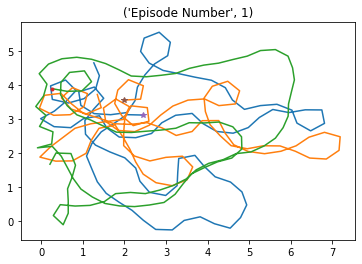

Episode * 2 * Avg Reward is ==> 2463.2497580137897 : Ag1 Reward ==> 2441.177485856616 : Ag2 Reward ==> 2460.1872718929008 : Ev Reward ==> 87.48847740735435


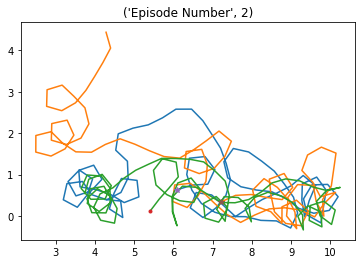

Episode * 3 * Avg Reward is ==> 2470.6033448876574 : Ag1 Reward ==> 2485.3105186353923 : Ag2 Reward ==> 2514.4799694324256 : Ev Reward ==> 69.66954729426438


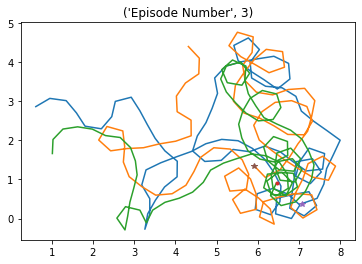

Episode * 4 * Avg Reward is ==> 2439.359806658035 : Ag1 Reward ==> 2345.629191969168 : Ag2 Reward ==> 2238.2612662920374 : Ev Reward ==> 165.0899337361621


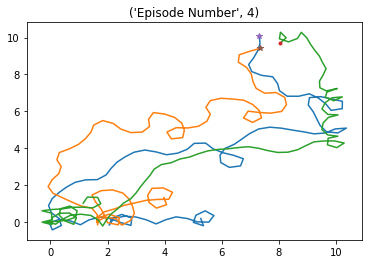

Episode * 5 * Avg Reward is ==> 2442.008141854666 : Ag1 Reward ==> 2452.6014826411897 : Ag2 Reward ==> 2425.6641052159202 : Ev Reward ==> 57.18404604041159


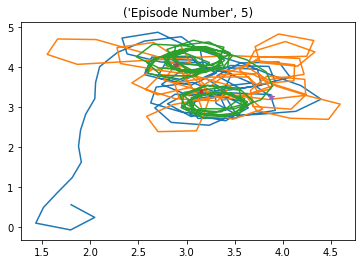

0
1
2
Episode * 6 * Avg Reward is ==> 2438.1813207569135 : Ag1 Reward ==> 2419.0472152681523 : Ag2 Reward ==> 2388.996355120593 : Ev Reward ==> 153.24146732674836


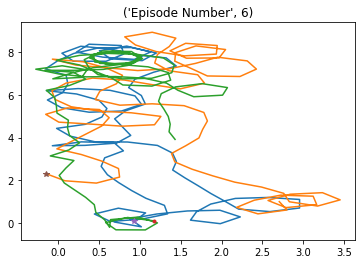

Episode * 7 * Avg Reward is ==> 2411.4989550541354 : Ag1 Reward ==> 2251.404760837465 : Ag2 Reward ==> 2098.9555153465485 : Ev Reward ==> 281.09373311526514


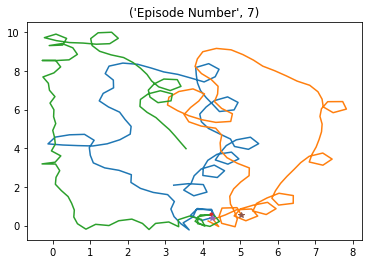

Episode * 8 * Avg Reward is ==> 2417.7776825172127 : Ag1 Reward ==> 2461.7287747587557 : Ag2 Reward ==> 2378.507117816246 : Ev Reward ==> 73.89414561081082


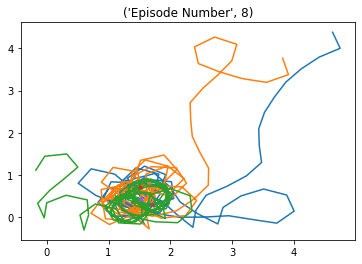

Episode * 9 * Avg Reward is ==> 2418.893551278391 : Ag1 Reward ==> 2427.8205013678157 : Ag2 Reward ==> 2392.5660519056723 : Ev Reward ==> 50.08721632130946


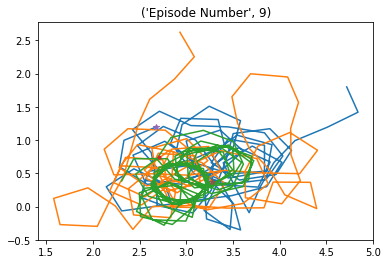

Episode * 10 * Avg Reward is ==> 2422.987327492888 : Ag1 Reward ==> 2459.8313134233645 : Ag2 Reward ==> 2446.2139431596347 : Ev Reward ==> 83.63019677777086


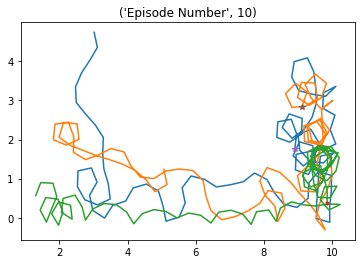

0
1
2
Episode * 11 * Avg Reward is ==> 2418.075076505847 : Ag1 Reward ==> 2368.9525666354357 : Ag2 Reward ==> 2401.0788470020157 : Ev Reward ==> 75.81286988515215


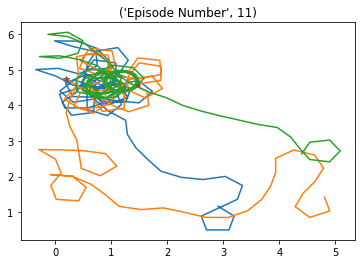

Episode * 12 * Avg Reward is ==> 2408.4401600369724 : Ag1 Reward ==> 2302.4560788793506 : Ag2 Reward ==> 2187.3808422823345 : Ev Reward ==> 262.34418759670956


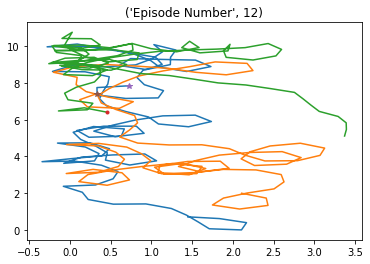

Episode * 13 * Avg Reward is ==> 2408.3088735197516 : Ag1 Reward ==> 2406.733435313104 : Ag2 Reward ==> 2401.896150037114 : Ev Reward ==> 113.8185625773142


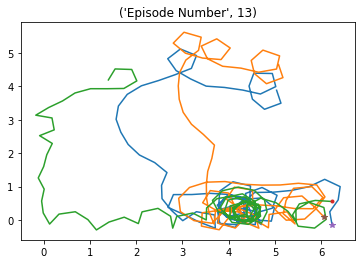

Episode * 14 * Avg Reward is ==> 2405.9218342567497 : Ag1 Reward ==> 2374.8903238377193 : Ag2 Reward ==> 2258.2657340992328 : Ev Reward ==> 128.21855940040916


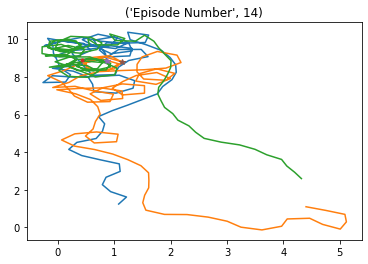

Episode * 15 * Avg Reward is ==> 2400.4079086672546 : Ag1 Reward ==> 2323.212950414326 : Ag2 Reward ==> 2206.5939736943187 : Ev Reward ==> 228.0744295446468


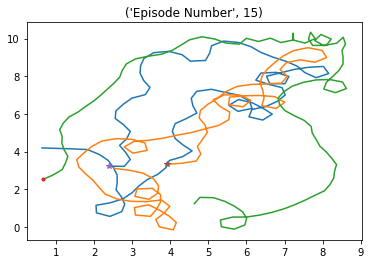

0
1
2
Episode * 16 * Avg Reward is ==> 2400.9427286938158 : Ag1 Reward ==> 2408.9650290922336 : Ag2 Reward ==> 2293.263664611419 : Ev Reward ==> 138.02626338775886


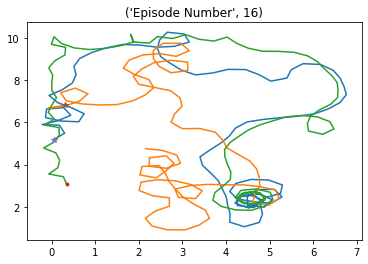

Episode * 17 * Avg Reward is ==> 2403.9597230335094 : Ag1 Reward ==> 2452.2316324686003 : Ag2 Reward ==> 2451.2738282489922 : Ev Reward ==> 87.3624940446311


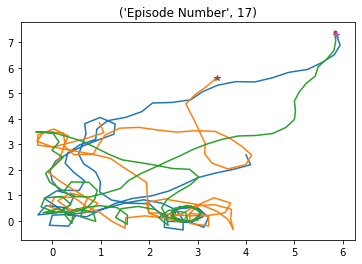

Episode * 18 * Avg Reward is ==> 2406.750719379124 : Ag1 Reward ==> 2454.197657254575 : Ag2 Reward ==> 2313.0111415785964 : Ev Reward ==> 163.90648824889948


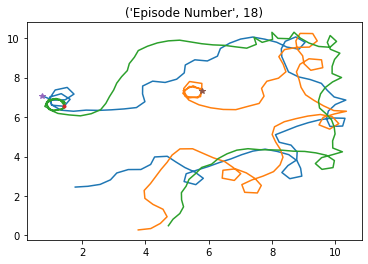

Episode * 19 * Avg Reward is ==> 2406.1965934688274 : Ag1 Reward ==> 2396.2223270834907 : Ag2 Reward ==> 2395.58496077086 : Ev Reward ==> 96.12114606662674


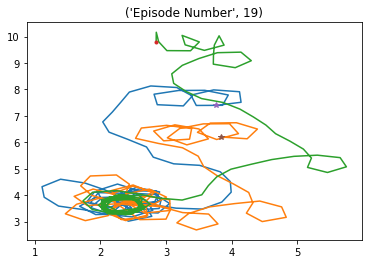

Episode * 20 * Avg Reward is ==> 2411.998631489214 : Ag1 Reward ==> 2522.2373538765614 : Ag2 Reward ==> 2522.6064509489865 : Ev Reward ==> 126.49937106713838


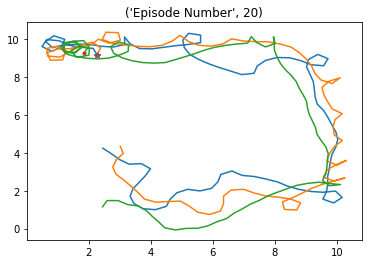

0
1
2
Episode * 21 * Avg Reward is ==> 2402.0871931313054 : Ag1 Reward ==> 2203.8584259731356 : Ag2 Reward ==> 2086.272562692098 : Ev Reward ==> 244.05926850496328


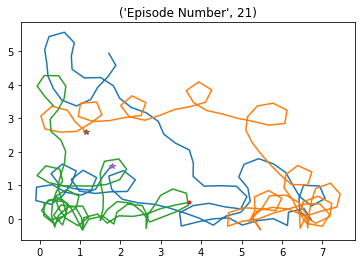

Episode * 22 * Avg Reward is ==> 2402.6776928581294 : Ag1 Reward ==> 2415.0781871214344 : Ag2 Reward ==> 2323.47176681378 : Ev Reward ==> 201.01219873491664


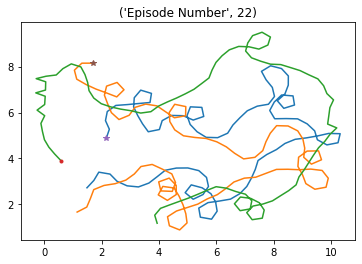

Episode * 23 * Avg Reward is ==> 2408.554812822796 : Ag1 Reward ==> 2537.8514520454637 : Ag2 Reward ==> 2529.141543930095 : Ev Reward ==> 69.01812810741427


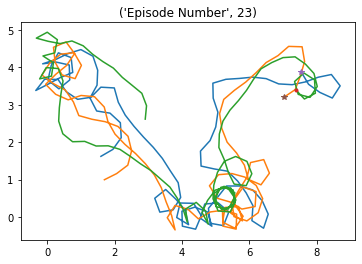

Episode * 24 * Avg Reward is ==> 2405.935896618768 : Ag1 Reward ==> 2345.700823926113 : Ag2 Reward ==> 2366.0763254092444 : Ev Reward ==> 148.42069425271117


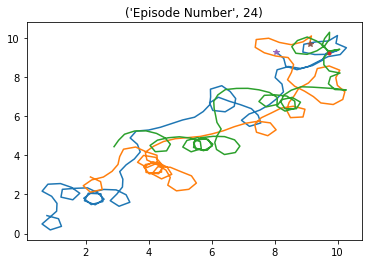

Episode * 25 * Avg Reward is ==> 2404.111183366368 : Ag1 Reward ==> 2360.318065308779 : Ag2 Reward ==> 2272.755503641369 : Ev Reward ==> 163.78539489023458


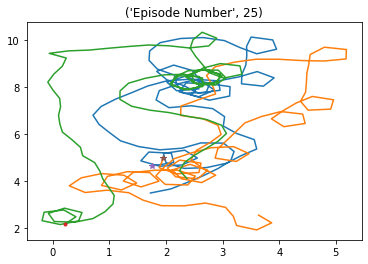

0
1
2
Episode * 26 * Avg Reward is ==> 2404.8640022517716 : Ag1 Reward ==> 2423.68447438686 : Ag2 Reward ==> 2390.1886806029556 : Ev Reward ==> 113.09812416641017


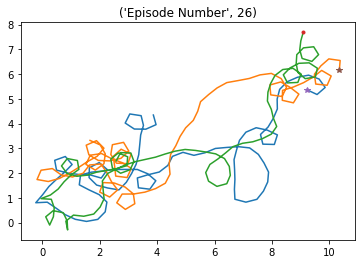

Episode * 27 * Avg Reward is ==> 2406.2413127271375 : Ag1 Reward ==> 2442.0513850866546 : Ag2 Reward ==> 2456.907733238941 : Ev Reward ==> 100.47283314570963


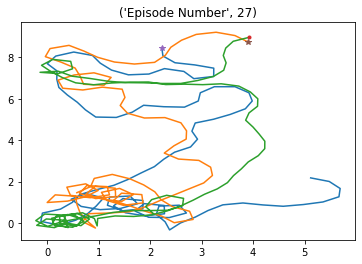

Episode * 28 * Avg Reward is ==> 2407.729919422563 : Ag1 Reward ==> 2447.9223001990404 : Ag2 Reward ==> 2345.22493026878 : Ev Reward ==> 176.39242671937495


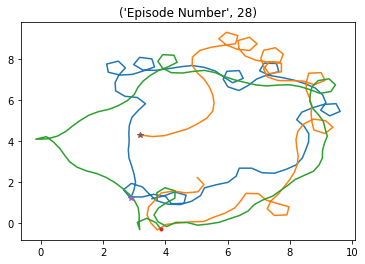

Episode * 29 * Avg Reward is ==> 2405.501329156394 : Ag1 Reward ==> 2343.1008017036656 : Ag2 Reward ==> 2276.4703030877176 : Ev Reward ==> 252.12703804014956


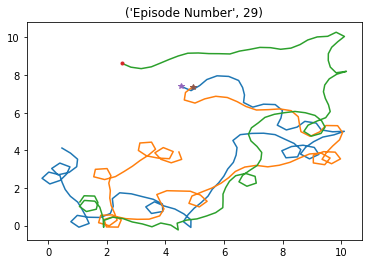

Episode * 30 * Avg Reward is ==> 2407.1459757583193 : Ag1 Reward ==> 2454.8407272141485 : Ag2 Reward ==> 2409.615823291846 : Ev Reward ==> 112.80116920965861


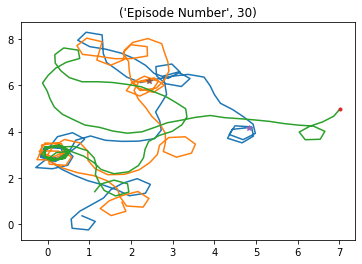

0
1
2
Episode * 31 * Avg Reward is ==> 2403.299974854561 : Ag1 Reward ==> 2287.91994774181 : Ag2 Reward ==> 2161.389106724852 : Ev Reward ==> 240.33501580187286


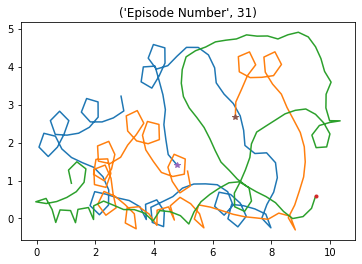

Episode * 32 * Avg Reward is ==> 2403.4614711665467 : Ag1 Reward ==> 2408.467856838119 : Ag2 Reward ==> 2364.4474999097483 : Ev Reward ==> 120.49834416152666


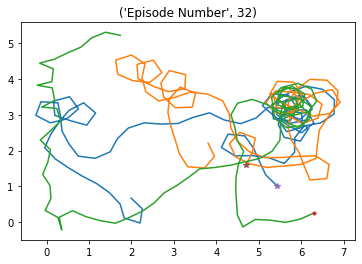

Episode * 33 * Avg Reward is ==> 2404.6551106452803 : Ag1 Reward ==> 2442.85157396475 : Ag2 Reward ==> 2347.6756307456085 : Ev Reward ==> 134.92967355487687


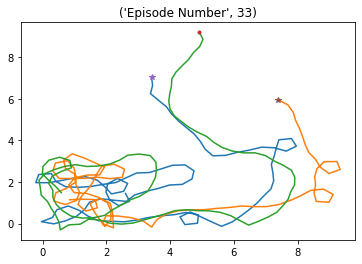

Episode * 34 * Avg Reward is ==> 2406.235971561063 : Ag1 Reward ==> 2458.4043817818915 : Ag2 Reward ==> 2426.5978369367413 : Ev Reward ==> 126.36820391147128


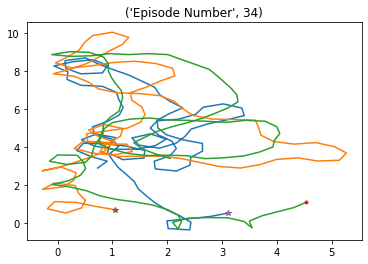

Episode * 35 * Avg Reward is ==> 2407.752767456955 : Ag1 Reward ==> 2459.323827917294 : Ag2 Reward ==> 2441.4011049554965 : Ev Reward ==> 107.59702426902307


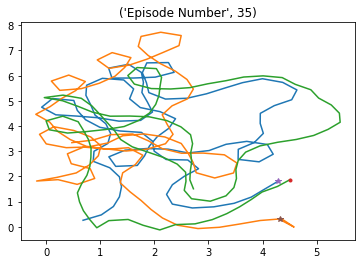

0
1
2
Episode * 36 * Avg Reward is ==> 2410.362272335462 : Ag1 Reward ==> 2501.694943083193 : Ag2 Reward ==> 2357.575662052066 : Ev Reward ==> 138.20768098897642


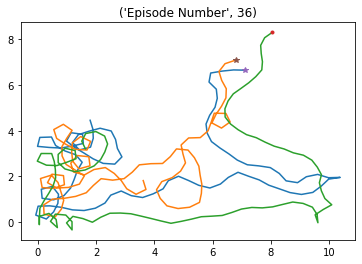

Episode * 37 * Avg Reward is ==> 2409.5669180064892 : Ag1 Reward ==> 2380.9341621634862 : Ag2 Reward ==> 2338.6329990037398 : Ev Reward ==> 123.38696876287365


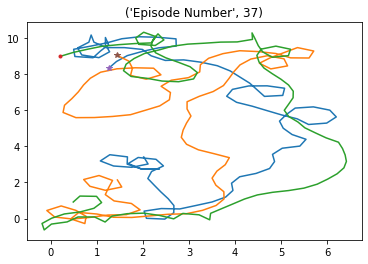

Episode * 38 * Avg Reward is ==> 2410.158804191287 : Ag1 Reward ==> 2432.0585930287957 : Ag2 Reward ==> 2449.8502223008404 : Ev Reward ==> 111.47702641657617


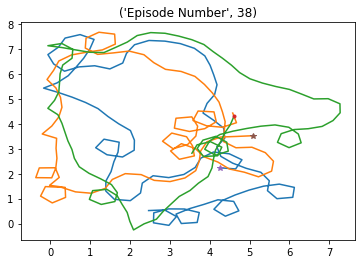

Episode * 39 * Avg Reward is ==> 2411.384953311426 : Ag1 Reward ==> 2457.97861987672 : Ag2 Reward ==> 2504.657797443321 : Ev Reward ==> 111.20547060079282


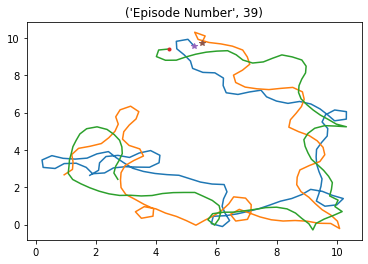

Episode * 40 * Avg Reward is ==> 2412.860961441316 : Ag1 Reward ==> 2470.4252785069943 : Ag2 Reward ==> 2476.9761850229725 : Ev Reward ==> 146.14088027202533


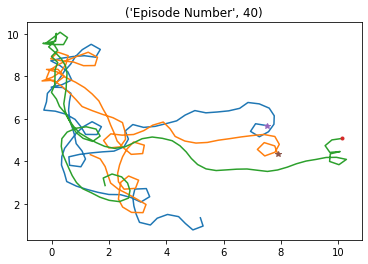

0
1
2
Episode * 41 * Avg Reward is ==> 2411.387067150493 : Ag1 Reward ==> 2426.366258538046 : Ag2 Reward ==> 2475.3453825542683 : Ev Reward ==> 122.12162958165555


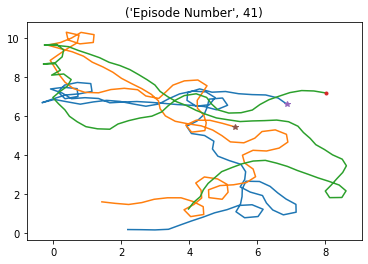

Episode * 42 * Avg Reward is ==> 2412.1528272500664 : Ag1 Reward ==> 2471.8078898395597 : Ag2 Reward ==> 2391.447404451843 : Ev Reward ==> 151.06747197134698


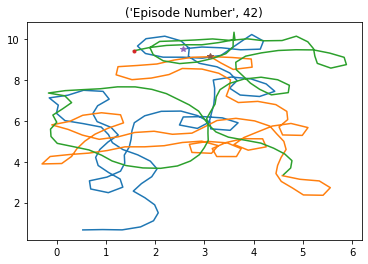

Episode * 43 * Avg Reward is ==> 2410.800375187728 : Ag1 Reward ==> 2431.2124361418546 : Ag2 Reward ==> 2366.544905228862 : Ev Reward ==> 167.27265041031816


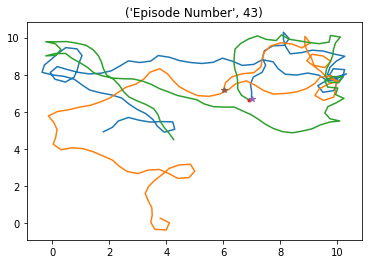

Episode * 44 * Avg Reward is ==> 2415.1310616587616 : Ag1 Reward ==> 2518.8566508105273 : Ag2 Reward ==> 2396.0045702217394 : Ev Reward ==> 123.28121848932639


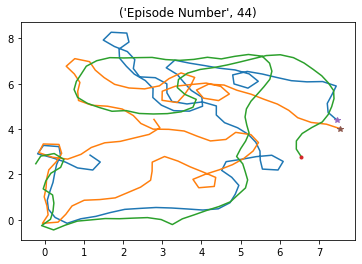

Episode * 45 * Avg Reward is ==> 2412.392632804005 : Ag1 Reward ==> 2343.06432845092 : Ag2 Reward ==> 2412.483573020214 : Ev Reward ==> 152.62172454233888


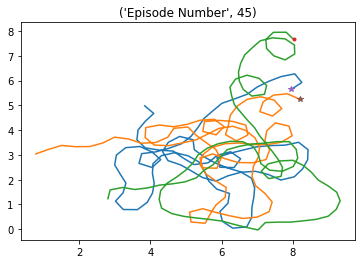

0
1
2
Episode * 46 * Avg Reward is ==> 2411.2190143912158 : Ag1 Reward ==> 2372.1024787565775 : Ag2 Reward ==> 2250.935415143494 : Ev Reward ==> 165.40121544465765


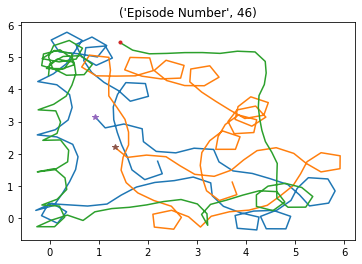

Episode * 47 * Avg Reward is ==> 2416.3770317325752 : Ag1 Reward ==> 2457.725454491852 : Ag2 Reward ==> 2363.479878197293 : Ev Reward ==> 136.36026519030983


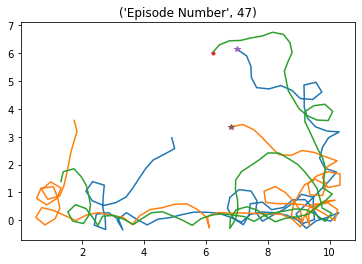

Episode * 48 * Avg Reward is ==> 2413.133093213483 : Ag1 Reward ==> 2331.9712339950524 : Ag2 Reward ==> 2207.6455295973255 : Ev Reward ==> 205.44576164074843


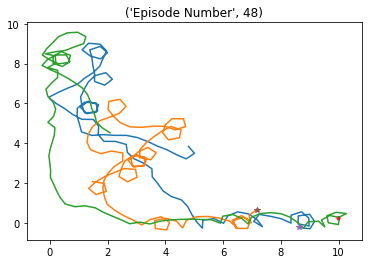

Episode * 49 * Avg Reward is ==> 2413.2591982322397 : Ag1 Reward ==> 2432.8647021180864 : Ag2 Reward ==> 2317.9638284149523 : Ev Reward ==> 130.10228978839808


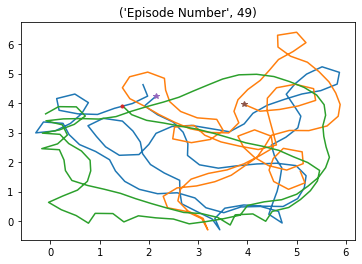

Episode * 50 * Avg Reward is ==> 2413.073572972243 : Ag1 Reward ==> 2452.406303023496 : Ag2 Reward ==> 2466.04299330851 : Ev Reward ==> 88.3904023074803


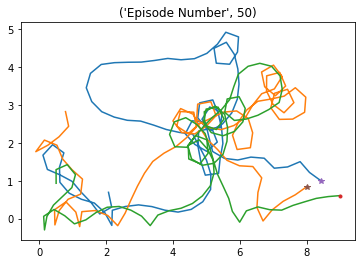

0
1
2
Episode * 51 * Avg Reward is ==> 2415.4554098839994 : Ag1 Reward ==> 2464.2260431056966 : Ag2 Reward ==> 2441.480750728945 : Ev Reward ==> 105.51970396308623


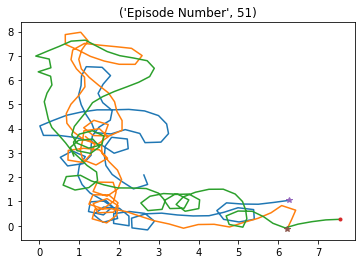

Episode * 52 * Avg Reward is ==> 2419.425700910497 : Ag1 Reward ==> 2461.2677199392488 : Ag2 Reward ==> 2432.1556217546417 : Ev Reward ==> 124.22234355051589


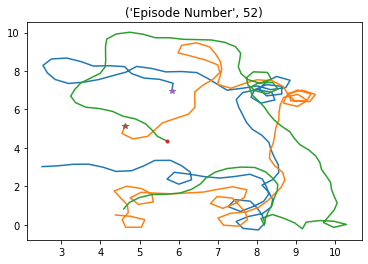

Episode * 53 * Avg Reward is ==> 2421.3785373193873 : Ag1 Reward ==> 2484.8468916687207 : Ag2 Reward ==> 2469.2012184786495 : Ev Reward ==> 102.57528538984648


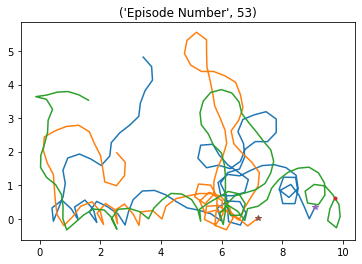

Episode * 54 * Avg Reward is ==> 2423.981595865459 : Ag1 Reward ==> 2479.012665680579 : Ag2 Reward ==> 2514.485233226226 : Ev Reward ==> 100.45672853658395


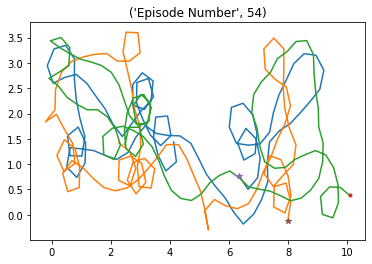

Episode * 55 * Avg Reward is ==> 2426.901982092516 : Ag1 Reward ==> 2440.028399496607 : Ag2 Reward ==> 2362.416011424321 : Ev Reward ==> 150.041880223092


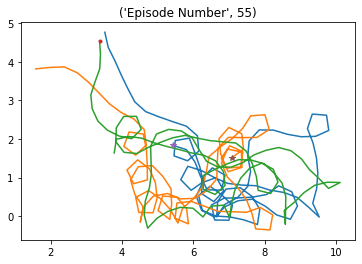

0
1
2
Episode * 56 * Avg Reward is ==> 2428.436065606404 : Ag1 Reward ==> 2470.328369647748 : Ag2 Reward ==> 2414.469188510885 : Ev Reward ==> 142.29869032788122


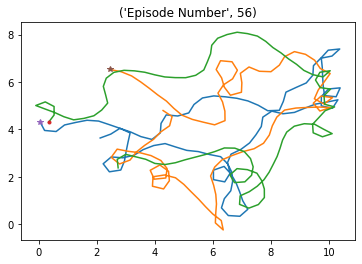

Episode * 57 * Avg Reward is ==> 2428.4947049539724 : Ag1 Reward ==> 2454.5772063713484 : Ag2 Reward ==> 2349.7678785879484 : Ev Reward ==> 143.4221742312753


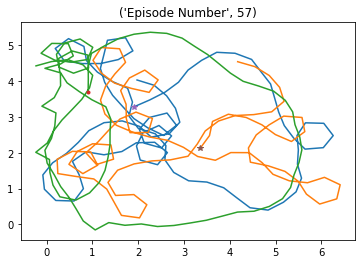

Episode * 58 * Avg Reward is ==> 2425.079169755939 : Ag1 Reward ==> 2317.576249333245 : Ag2 Reward ==> 2159.4680544710354 : Ev Reward ==> 198.26167626511344


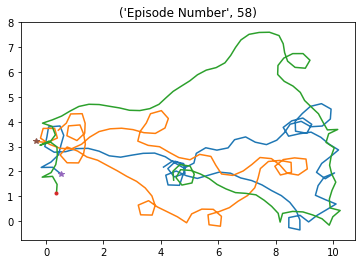

Episode * 59 * Avg Reward is ==> 2425.1114309543855 : Ag1 Reward ==> 2397.5127750213483 : Ag2 Reward ==> 2308.3365004373068 : Ev Reward ==> 197.67405399760273


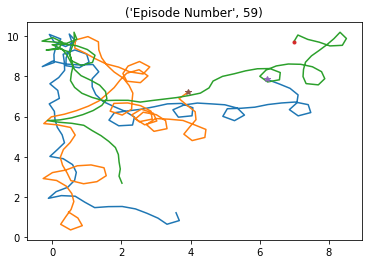

Episode * 60 * Avg Reward is ==> 2423.62269874048 : Ag1 Reward ==> 2462.688065320329 : Ag2 Reward ==> 2391.6935940446124 : Ev Reward ==> 154.06538561933218


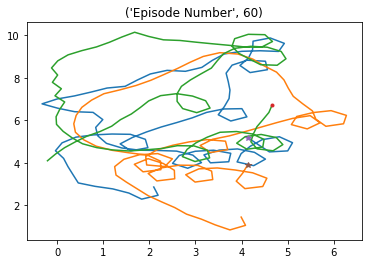

0
1
2
Episode * 61 * Avg Reward is ==> 2430.0602206075496 : Ag1 Reward ==> 2461.3593006559167 : Ag2 Reward ==> 2296.7503555872913 : Ev Reward ==> 194.19263470467195


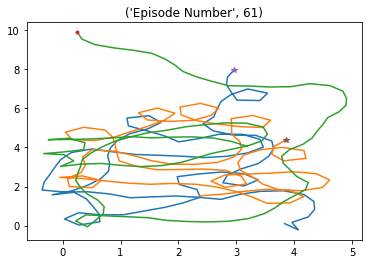

Episode * 62 * Avg Reward is ==> 2430.019054329435 : Ag1 Reward ==> 2413.4315359968627 : Ag2 Reward ==> 2355.9425078758863 : Ev Reward ==> 180.0671883548276


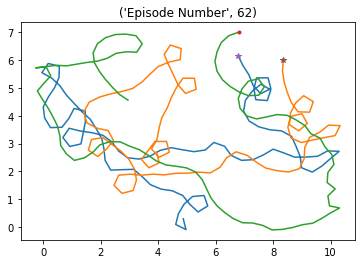

Episode * 63 * Avg Reward is ==> 2425.5530951300834 : Ag1 Reward ==> 2359.2130840713835 : Ag2 Reward ==> 2336.751176100994 : Ev Reward ==> 153.73665949267104


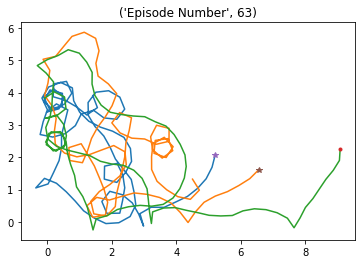

Episode * 64 * Avg Reward is ==> 2426.868842219177 : Ag1 Reward ==> 2398.330707489885 : Ag2 Reward ==> 2314.55911891008 : Ev Reward ==> 164.7156058810935


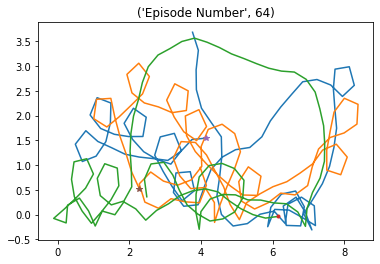

Episode * 65 * Avg Reward is ==> 2424.8944557486034 : Ag1 Reward ==> 2281.3426064858086 : Ag2 Reward ==> 2123.2548039582384 : Ev Reward ==> 191.80954399214994


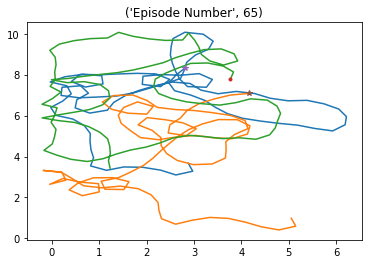

0
1
2
Episode * 66 * Avg Reward is ==> 2426.7061494863133 : Ag1 Reward ==> 2496.1522238952775 : Ag2 Reward ==> 2407.041673507292 : Ev Reward ==> 145.712256993815


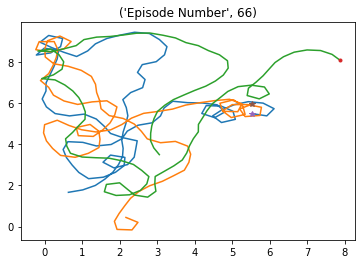

Episode * 67 * Avg Reward is ==> 2424.9518141049834 : Ag1 Reward ==> 2371.8779698334365 : Ag2 Reward ==> 2250.3700292050717 : Ev Reward ==> 201.02875061218998


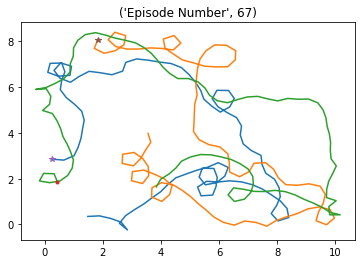

Episode * 68 * Avg Reward is ==> 2422.039317616466 : Ag1 Reward ==> 2331.4224406583376 : Ag2 Reward ==> 2161.8150085345846 : Ev Reward ==> 166.99986740872848


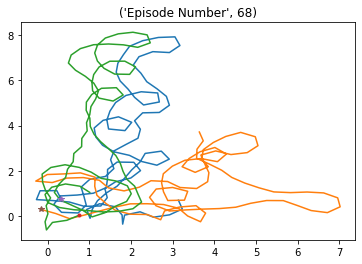

Episode * 69 * Avg Reward is ==> 2425.55312525364 : Ag1 Reward ==> 2483.6531071906434 : Ag2 Reward ==> 2497.234701887173 : Ev Reward ==> 103.74304274604785


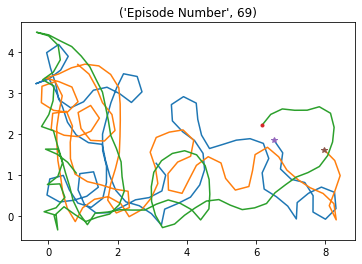

Episode * 70 * Avg Reward is ==> 2419.6184567736336 : Ag1 Reward ==> 2217.453988013891 : Ag2 Reward ==> 2384.479324108738 : Ev Reward ==> 164.0137913569574


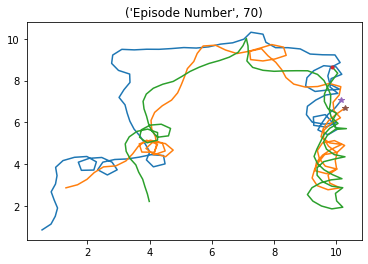

0
1
2
Episode * 71 * Avg Reward is ==> 2423.5530925140893 : Ag1 Reward ==> 2445.3053773600286 : Ag2 Reward ==> 2441.8156201998963 : Ev Reward ==> 103.93653040332556


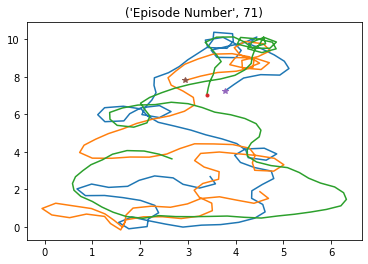

Episode * 72 * Avg Reward is ==> 2423.3956184856024 : Ag1 Reward ==> 2402.1688956986586 : Ag2 Reward ==> 2292.216909580148 : Ev Reward ==> 139.8183693137054


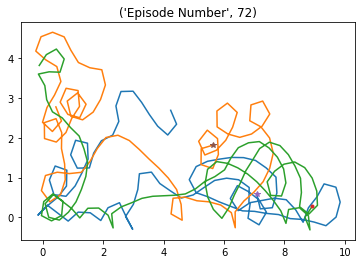

Episode * 73 * Avg Reward is ==> 2423.457502631397 : Ag1 Reward ==> 2445.3269397965346 : Ag2 Reward ==> 2440.426286580904 : Ev Reward ==> 117.01071066107787


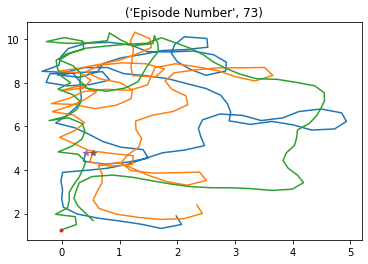

Episode * 74 * Avg Reward is ==> 2417.6906692698967 : Ag1 Reward ==> 2227.7310473218936 : Ag2 Reward ==> 2207.5011145242147 : Ev Reward ==> 167.4221993121001


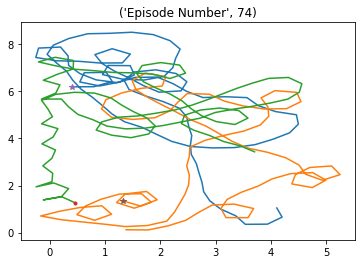

Episode * 75 * Avg Reward is ==> 2417.309994454514 : Ag1 Reward ==> 2444.0968353019666 : Ag2 Reward ==> 2498.375587064895 : Ev Reward ==> 129.991616439236


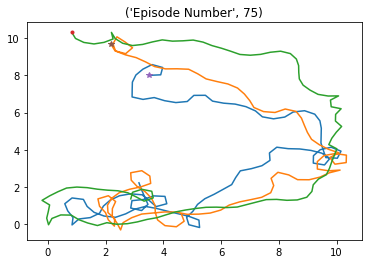

0
1
2
Episode * 76 * Avg Reward is ==> 2413.8496901752833 : Ag1 Reward ==> 2363.2827719139896 : Ag2 Reward ==> 2260.2852374717045 : Ev Reward ==> 152.04750694500703


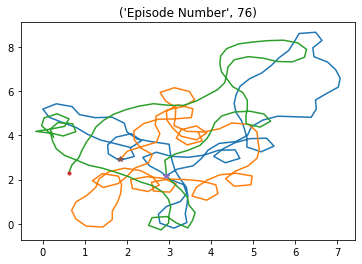

Episode * 77 * Avg Reward is ==> 2417.2947715021387 : Ag1 Reward ==> 2518.737415237684 : Ag2 Reward ==> 2487.77293323054 : Ev Reward ==> 98.96449578921833


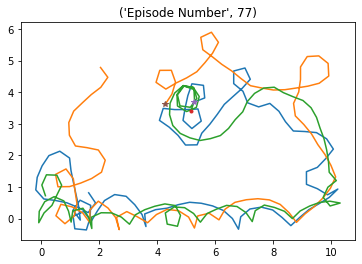

Episode * 78 * Avg Reward is ==> 2414.7655476297896 : Ag1 Reward ==> 2330.889638134839 : Ag2 Reward ==> 2202.2940634003585 : Ev Reward ==> 189.74582798860658


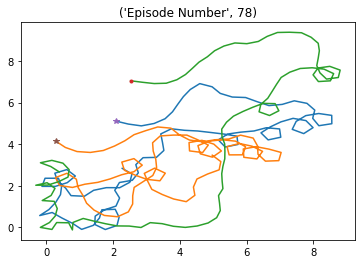

Episode * 79 * Avg Reward is ==> 2415.4813341801046 : Ag1 Reward ==> 2486.6100818893115 : Ag2 Reward ==> 2416.9031441852258 : Ev Reward ==> 135.443655335279


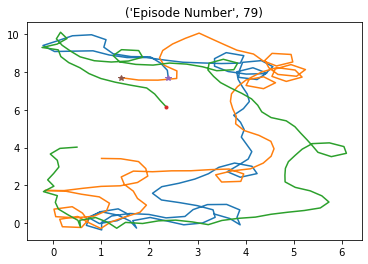

Episode * 80 * Avg Reward is ==> 2414.324533002601 : Ag1 Reward ==> 2424.153231406866 : Ag2 Reward ==> 2369.6017881627895 : Ev Reward ==> 155.83821296091935


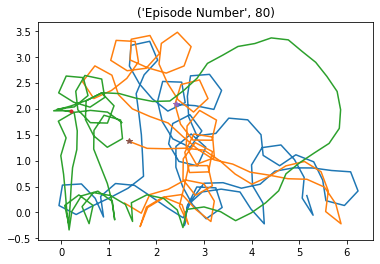

0
1
2
Episode * 81 * Avg Reward is ==> 2410.995559688992 : Ag1 Reward ==> 2293.207325993676 : Ag2 Reward ==> 2181.4305585656716 : Ev Reward ==> 169.61836474550245


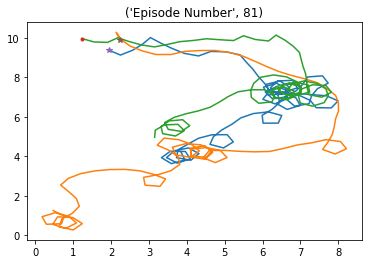

Episode * 82 * Avg Reward is ==> 2408.157112668526 : Ag1 Reward ==> 2358.27000902093 : Ag2 Reward ==> 2121.9082119751265 : Ev Reward ==> 198.6916850947522


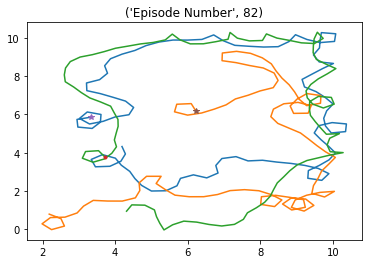

KeyboardInterrupt: ignored

In [ ]:

ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

ag1_reward_list = []
ag2_reward_list = []
ev_reward_list = []

# Takes about 20 min to train
for ep in range(num_episodes):

    env = environment()
    prev_state = env.initial_obs()

    
    episodic_reward = 0
    ag1_reward = 0
    ag2_reward = 0
    ev_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []

    
    #while True:
    for i in range(num_steps):
        
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        actions = []
        for j, model in enumerate(ac_models):
          action = policy(tf_prev_state[:,5*j:5*(j+1)], ou_noise, model)
          actions.append(float(action[0]))
          

        # Recieve state and reward from environment.
        #new_state, sys_state, ev_state = transition(prev_state, sys_state, actions, ev_state)
        new_state = env.step(actions)
        rewards = reward(new_state)

        buffer.record((prev_state, actions, rewards, new_state))
        
        episodic_reward += sum(rewards[:1])
        ag1_reward += rewards[0]
        ag2_reward += rewards[1]
        ev_reward += rewards[2]

        buffer.learn(ac_models, cr_models, target_ac, target_cr)
        update_target(tau, ac_models, cr_models, target_ac, target_cr)

        prev_state = new_state
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)
        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)
        
        xce.append(env.e_rx)
        yce.append(env.e_ry)

    
    if ep%5 == 0:
        
      for k in range(num_agents):
        print(k)
        ac_models[k].save('/content/drive/MyDrive/MS_Project/actor'+str(k)+'.h5') 
        cr_models[k].save('/content/drive/MyDrive/MS_Project/critic'+str(k)+'.h5')

        target_ac[k].save('/content/drive/MyDrive/MS_Project/target_actor' + str(k)+'.h5')
        target_cr[k].save('/content/drive/MyDrive/MS_Project/target_critic' + str(k)+'.h5')
    

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]

    ep_reward_list.append(episodic_reward)
    ag1_reward_list.append(ag1_reward)
    ag2_reward_list.append(ag2_reward)
    ev_reward_list.append(ev_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {} : Ag1 Reward ==> {} : Ag2 Reward ==> {} : Ev Reward ==> {}".format(ep+1, avg_reward, ag1_reward, ag2_reward, ev_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xp1,yp1)
    plt.plot(xp2,yp2)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.') 
    plt.plot(xp1[-1],yp1[-1],'*')
    plt.plot(xp2[-1],yp2[-1],'*')
    title = 'Episode Number', ep+1
    plt.title(title)
    plt.show()
    

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
for k in range(num_agents):
    print(k)
    ac_models[k].save('/save_models/actor'+str(k)+'.h5') 
    cr_models[k].save('/save_models/critic'+str(k)+'.h5') 

    target_ac[k].save('/save_models/target_actor' + str(k)+'.h5')
    target_cr[k].save('/save_models/target_critic' + str(k)+'.h5')

0
1
2


In [ ]:

for i in range(num_agents):
  ac_models[i].save('actor'+str(i)+'.h5') 
  cr_models[i].save('critic'+str(i)+'.h5')

  target_ac[i].save('target_actor' + str(i)+'.h5')
  target_cr[i].save('target_critic' + str(i)+'.h5')

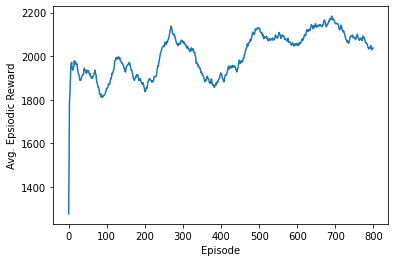

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.plot(avg_reward_list)

Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Captured
Episode * 1 * Avg Reward is ==> 28639.172988937666 : Ag1 Reward ==> 13949.928635901753 : Ag2 Reward ==> 14039.595922381168 : Ev Reward ==> 649.6484306547597


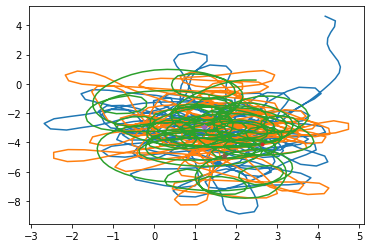

In [ ]:
dt = 0.4

v = 1.0
ve = 0.8


#rho = 3*v
#rho_e = 3*ve

def policy(state, noise_object, model):
    
    sampled_actions = tf.squeeze(model(state))
    noise = noise_object()

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + 0

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)

    return [np.squeeze(legal_action)]


ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

ag1_reward_list = []
ag2_reward_list = []
ev_reward_list = []

# Takes about 20 min to train
for ep in range(1):

    env = environment()
    prev_state = env.initial_obs()

    
    episodic_reward = 0
    ag1_reward = 0
    ag2_reward = 0
    ev_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []

    
    #while True:
    for i in range(600):
        
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        actions = []
        for j, model in enumerate(ac_models):
          action = policy(tf_prev_state[:,5*j:5*(j+1)], ou_noise, model)
          actions.append(float(action[0]))
          

        # Recieve state and reward from environment.
        #new_state, sys_state, ev_state = transition(prev_state, sys_state, actions, ev_state)
        new_state = env.step(actions)
        rewards = reward(new_state)

        #buffer.record((prev_state, actions, rewards, new_state))
        
        episodic_reward += sum(rewards)
        ag1_reward += rewards[0]
        ag2_reward += rewards[1]
        ev_reward += rewards[2]

        '''buffer.learn(ac_models, cr_models, target_ac, target_cr)
        update_target(tau, ac_models, cr_models, target_ac, target_cr)'''

        prev_state = new_state
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)
        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)
        
        xce.append(env.e_rx)
        yce.append(env.e_ry)

        d_p1_e = L(env.p1_rx, env.p1_ry, env.e_rx, env.e_ry)
        d_p2_e = L(env.p2_rx, env.p2_ry, env.e_rx, env.e_ry)

        if d_p1_e < 0.4 or d_p2_e < 0.4:
          #env = environment()
          #prev_state = env.initial_obs()
          print("Captured")
          #break

    


    xc1 = [env.e_rx]
    yc1 = [env.e_ry]

    ep_reward_list.append(episodic_reward)
    ag1_reward_list.append(ag1_reward)
    ag2_reward_list.append(ag2_reward)
    ev_reward_list.append(ev_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {} : Ag1 Reward ==> {} : Ag2 Reward ==> {} : Ev Reward ==> {}".format(ep+1, avg_reward, ag1_reward, ag2_reward, ev_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xp1,yp1)
    plt.plot(xp2,yp2)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.') 
    plt.plot(xp1[-1],yp1[-1],'*')
    plt.plot(xp2[-1],yp2[-1],'*')
  
    

# Plotting graph
# Episodes versus Avg. Rewards

plt.show()

Captured
Captured
Captured
Captured
Captured
Captured
Episode * 1 * Avg Reward is ==> 47393.62907932713 : Ag1 Reward ==> 22694.752640066225 : Ag2 Reward ==> 22764.19370319374 : Ev Reward ==> 1934.6827360671036


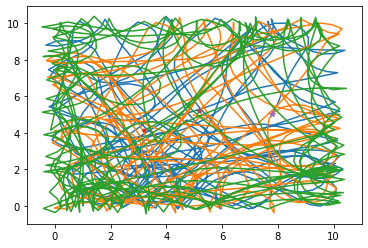

In [ ]:
dt = 0.4

v = 1.0
ve = 1.2


rho = v
rho_e = v

def policy(state, noise_object, model):
    
    sampled_actions = tf.squeeze(model(state))
    noise = noise_object()

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + 0

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)

    return [np.squeeze(legal_action)]


ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

ag1_reward_list = []
ag2_reward_list = []
ev_reward_list = []

# Takes about 20 min to train
for ep in range(1):

    env = environment()
    prev_state = env.initial_obs()

    
    episodic_reward = 0
    ag1_reward = 0
    ag2_reward = 0
    ev_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []

    
    #while True:
    for i in range(1000):
        
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        actions = []
        for j, model in enumerate(ac_models):
          action = policy(tf_prev_state[:,5*j:5*(j+1)], ou_noise, model)
          actions.append(float(action[0]))
          

        # Recieve state and reward from environment.
        #new_state, sys_state, ev_state = transition(prev_state, sys_state, actions, ev_state)
        new_state = env.step(actions)
        rewards = reward(new_state)

        #buffer.record((prev_state, actions, rewards, new_state))
        
        episodic_reward += sum(rewards)
        ag1_reward += rewards[0]
        ag2_reward += rewards[1]
        ev_reward += rewards[2]

        '''buffer.learn(ac_models, cr_models, target_ac, target_cr)
        update_target(tau, ac_models, cr_models, target_ac, target_cr)'''

        prev_state = new_state
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)
        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)
        
        xce.append(env.e_rx)
        yce.append(env.e_ry)

        d_p1_e = L(env.p1_rx, env.p1_ry, env.e_rx, env.e_ry)
        d_p2_e = L(env.p2_rx, env.p2_ry, env.e_rx, env.e_ry)

        if d_p1_e < 0.2 or d_p2_e < 0.2:
          env = environment()
          prev_state = env.initial_obs()
          print("Captured")
          #break

    


    xc1 = [env.e_rx]
    yc1 = [env.e_ry]

    ep_reward_list.append(episodic_reward)
    ag1_reward_list.append(ag1_reward)
    ag2_reward_list.append(ag2_reward)
    ev_reward_list.append(ev_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {} : Ag1 Reward ==> {} : Ag2 Reward ==> {} : Ev Reward ==> {}".format(ep+1, avg_reward, ag1_reward, ag2_reward, ev_reward))
    avg_reward_list.append(avg_reward)
    plt.plot(xp1,yp1)
    plt.plot(xp2,yp2)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.') 
    plt.plot(xp1[-1],yp1[-1],'*')
    plt.plot(xp2[-1],yp2[-1],'*')
  
    

# Plotting graph
# Episodes versus Avg. Rewards

plt.show()

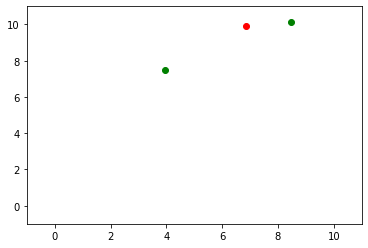

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-1, 11), ylim=(-1, 11))
line, = ax.plot([], [], 'go')
line1, = ax.plot([], [], 'go')
line2, = ax.plot([], [], 'ro')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    return line, line1, line2,

# animation function.  This is called sequentially
def animate(i):
    x = xp1[i-1:i]
    y = yp1[i-1:i]
    x2 = xp2[i-1:i]
    y2 = yp2[i-1:i]
    x_ = xce[i-1:i]
    y_ = yce[i-1:i]
    line.set_data(x, y)
    line1.set_data(x2, y2)
    line2.set_data(x_, y_)
    return line, line1, line2,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=1, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

plt.show()

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
100%100

0

In [ ]:
import time
start_time = time.time()
for k in range(num_agents):
    print(k)
    ac_models[k].save('/content/drive/MyDrive/MS_Project/actor'+str(k)+'.h5') 
    cr_models[k].save('/content/drive/MyDrive/MS_Project/critic'+str(k)+'.h5')

    target_ac[k].save('/content/drive/MyDrive/MS_Project/target_actor' + str(k)+'.h5')
    target_cr[k].save('/content/drive/MyDrive/MS_Project/target_critic' + str(k)+'.h5')


print(  time.time()-start_time)

0
1
2
0.6178126335144043
